# Monte Carlo Methods
# Part 0: Explore BlackJackEnv

In [1]:
import sys
import gym
from gym.wrappers import TransformObservation
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v1', apply_api_compatibility=False)

The agent has tro potential actions:

        STICK = 0
        HIT = 1

        
        Verify this by running the cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
env = TransformObservation(env, lambda obs: (obs[0], obs[1], int(obs[2])))

state, info = env.reset()
print("State:", state)

State: (11, 2, 0)


In [5]:
for i_episode in range(3):
    state, info = env.reset()  # Modern API returns a tuple (state, info)
    while True:
        print(f"State: {state}")
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:  # End the game if either condition is met
            print('End game! Reward: ', reward)
            print('You won :) \n' if reward > 0 else 'You lost :(\n')
            break

State: (12, 7, 0)
State: (18, 7, 0)
End game! Reward:  1.0
You won :) 

State: (12, 10, 0)
State: (18, 10, 0)
End game! Reward:  -1.0
You lost :(

State: (18, 8, 1)
State: (14, 8, 0)
End game! Reward:  -1.0
You lost :(



/Users/adwiz/miniconda3/envs/rl/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Part 1: MC Prediction
In this section, you will write your own implementation of MC prediction (for estimation the action-value function)

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state, info = bj_env.reset()
    while True:
        # Extract player_sum from the tuple
        player_sum = state[0]
        
        # Define probabilities
        probs = [0.8, 0.2] if player_sum > 18 else [0.2, 0.8]
        
        # Select an action
        action = np.random.choice(np.arange(2), p=probs)
        
        # Step in the environment
        next_state, reward, terminated, truncated, info = bj_env.step(action)
        episode.append((state, action, reward))
        
        state = next_state
        
        # End the episode
        if terminated or truncated:
            break
    return episode


In [11]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((8, 4, 0), 0, -1.0)]
[((19, 4, 0), 0, 1.0)]
[((10, 10, 0), 1, 0.0), ((13, 10, 0), 1, -1.0)]


In [37]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print('\rEpisode {}/{}.'.format(i_episode, num_episodes), end='')
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value
        # function extimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [38]:
episode = generate_episode_from_limit_stochastic(env)
print(episode)
states, actions, rewards = zip(*episode)
print('\nstates', states)
print('\nactions', actions)
print('\nrewards', rewards)

[((21, 9, 1), 0, 1.0)]

states ((21, 9, 1),)

actions (0,)

rewards (1.0,)


Episode 500000/500000.

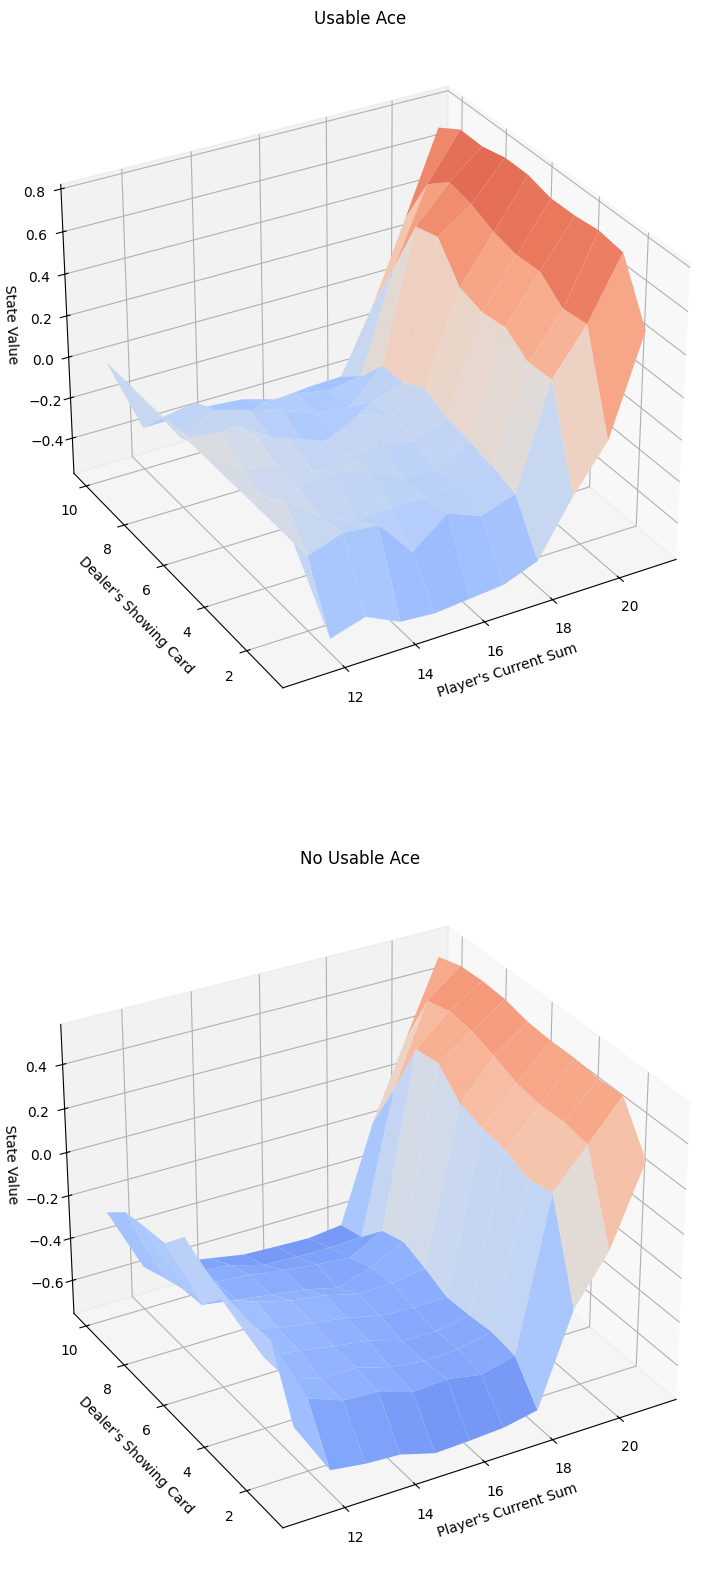

In [41]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obrain the corresponding state-value function
V_to_plot =  dict((k, (k[0]>18)*(np.dot([0.8, 0.2], v)) + (k[0]<=18)*(np.dot([.2, .8], v))) \
         for k, v in Q.items())
# plot the state-value function
plot_blackjack_values(V_to_plot)